In [1]:
# Forces the notebook to always reload packages.
%reload_ext autoreload
%autoreload 2

## Dataset loading

### Regular dataset loading

In [2]:
from python_proj.utils.util import Counter
import python_proj.utils.exp_utils as exp_utils

# Defines a number of constants.

file_name = "dataset_transformed"
base_path = exp_utils.BASE_PATH
data_path = f"{base_path}/final_data/{file_name}.csv"
figure_base_path = f"{base_path}/figures/modelling/{file_name}/rf_nftc/"

# Meta stuff.
pr_merged_key = "PullRequestIsMerged"
ftc_key = "SubmitterIsFirstTimeContributor"
seed_counter = Counter()

In [3]:
import pandas as pd
import numpy as np
import json


# Loads regular dataframe.
df: pd.DataFrame = pd.read_csv(filepath_or_buffer=data_path, header=0)

# Creates sub-datasets.
metadata_fields = ["ID", "Project Name", "Submitter ID", "PR Number", "Closed At"]
dependent_fields = [pr_merged_key]

df.describe()

,ID,Submitter ID,PR Number,IntraProjectSubmitterPullRequestSuccessRate,EcosystemExperienceSubmitterPullRequestSuccessRate,DependencyEcosystemExperienceSubmitterPullRequestSuccessRate,NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,ln(1 + ControlPullRequestLifeTimeInMinutes),ln(1 + ControlNumberOfCommitsInPullRequest),...,ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + NonDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + NonDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + WeightedEcosystemSecondOrderDegreeCentrality),ln(1 + WeightedIntraProjectSecondOrderDegreeCentrality),ln(1 + EcosystemLinkIntensity),ln(1 + IntraProjectLinkIntensity)
count,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,...,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06
mean,1.473092e+08,5.092504e+06,8.089130e+02,5.029367e-01,4.028501e-01,9.853429e-02,3.751776e-01,5.922709e-02,4.195426e-01,1.183858e-01,...,1.144450e-02,1.968795e-02,7.962418e-02,1.344287e-01,9.542167e-03,1.752697e-02,6.396780e-02,6.040052e-02,2.195312e-02,4.472791e-02
std,9.954409e+07,7.968202e+06,2.304617e+03,4.710606e-01,4.523397e-01,2.907111e-01,4.479337e-01,2.285036e-01,2.256901e-01,7.147764e-02,...,5.396848e-02,8.007560e-02,1.179799e-01,1.750052e-01,5.263118e-02,8.245257e-02,9.934566e-02,1.002992e-01,8.741610e-02,1.013945e-01
min,6.870000e+02,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.924867e+07,4.674710e+05,5.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.365158e-01,7.525668e-02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.366714e+08,1.633887e+06,1.990000e+02,6.800000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.433349e-01,7.525668e-02,...,0.000000e+00,0.000000e+00,0.000000e+00,7.753347e-02,0.000000e+00,0.000000e+00,8.453635e-03,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.260994e+08,6.254382e+06,6.840000e+02,1.000000e+00,9.391304e-01,0.000000e+00,9.230769e-01,0.000000e+00,5.863557e-01,1.505134e-01,...,0.000000e+00,0.000000e+00,1.416667e-01,2.326004e-01,0.000000e+00,0.000000e+00,9.892883e-02,8.837267e-02,0.000000e+00,2.582313e-02
max,3.617756e+08,5.973444e+07,8.297600e+04,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [4]:
print(list(df.columns))

['ID', 'Project Name', 'Submitter ID', 'PR Number', 'Closed At', 'PullRequestIsMerged', 'ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlPullRequestHasCommentByExternalUser', 'ControlHasHashTagInDescription', 'IntraProjectSubmitterPullRequestSuccessRate', 'EcosystemExperienceSubmitterPullRequestSuccessRate', 'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'SubmitterIsFirstTimeContributor', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)', 'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)', 'ln(1 + IntraProjectSubmitterPullRequestCommentCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + DependencyEcosystem

In [5]:
# Identifieds independent / predictor fields.


def is_independent_field(field: str) -> bool:
    return field not in metadata_fields and field != pr_merged_key


independent_fields = list(filter(is_independent_field, df.columns))

In [6]:
# Calculates class imbalance.
class_counts = df[pr_merged_key].value_counts()
class_imbalance = class_counts[True] / class_counts[False]
print(f"{class_imbalance=}")

class_imbalance=3.6991542286634957


### Sample only PRs by first-time contributors

In [7]:
# Filters data
df = df[df[ftc_key] == False]
df = df.drop([ftc_key], axis=1)
independent_fields.remove(ftc_key)
print(f"{len(df)=}")

# Recalculates class imbalance.
class_counts = df[pr_merged_key].value_counts()
class_imbalance = class_counts[True] / class_counts[False]
print(f"{class_imbalance=}")

# Resets indices.
df = df.reset_index(drop=True)
print(independent_fields)

df.describe()

len(df)=789389
class_imbalance=5.996516760321202
['ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlPullRequestHasCommentByExternalUser', 'ControlHasHashTagInDescription', 'IntraProjectSubmitterPullRequestSuccessRate', 'EcosystemExperienceSubmitterPullRequestSuccessRate', 'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)', 'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)', 'ln(1 + IntraProjectSubmitterPullRequestCommentCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + DependencyEcosys

,ID,Submitter ID,PR Number,IntraProjectSubmitterPullRequestSuccessRate,EcosystemExperienceSubmitterPullRequestSuccessRate,DependencyEcosystemExperienceSubmitterPullRequestSuccessRate,NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,ln(1 + ControlPullRequestLifeTimeInMinutes),ln(1 + ControlNumberOfCommitsInPullRequest),...,ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + NonDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + NonDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + WeightedEcosystemSecondOrderDegreeCentrality),ln(1 + WeightedIntraProjectSecondOrderDegreeCentrality),ln(1 + EcosystemLinkIntensity),ln(1 + IntraProjectLinkIntensity)
count,7.893890e+05,7.893890e+05,789389.000000,789389.000000,789389.000000,789389.000000,789389.000000,789389.000000,789389.000000,789389.000000,...,789389.000000,789389.000000,789389.000000,789389.000000,789389.000000,789389.000000,789389.000000,789389.000000,789389.000000,789389.000000
mean,1.613374e+08,5.071217e+06,929.996330,0.774881,0.477277,0.138873,0.439422,0.077817,0.380645,0.124870,...,0.016136,0.027668,0.091486,0.155980,0.012445,0.022748,0.072195,0.088793,0.026830,0.065518
std,9.890446e+07,7.946069e+06,2552.602012,0.362156,0.456992,0.336869,0.456628,0.259218,0.217298,0.075795,...,0.063825,0.093934,0.124459,0.183676,0.060300,0.093821,0.103604,0.111771,0.097241,0.119149
min,6.870000e+02,1.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.601776e+07,4.540660e+05,68.000000,0.750000,0.000000,0.000000,0.000000,0.000000,0.198106,0.075257,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.561170e+08,1.606068e+06,255.000000,0.977273,0.545455,0.000000,0.083333,0.000000,0.393710,0.075257,...,0.000000,0.000000,0.000000,0.077533,0.000000,0.000000,0.020509,0.044760,0.000000,0.000000
75%,2.410351e+08,6.193135e+06,806.000000,1.000000,0.967742,0.000000,0.960396,0.000000,0.545946,0.150513,...,0.000000,0.000000,0.141667,0.277955,0.000000,0.000000,0.114672,0.140823,0.000000,0.080350
max,3.617734e+08,5.943086e+07,82974.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.993928,...,1.000000,1.000000,0.854348,0.886162,0.999796,1.000000,0.922599,1.000000,1.000000,1.000000


## Model Creation

In [8]:
k = 5
print(f"Using {k=} folds.")

Using k=5 folds.


Generates a number of feature groups that are relevant later in the pipeline:
- control variables
- intra-project experience
- ecosystem experience
- dependency ecosystem experience
- inverse dependency ecosystem experience
- non-dependency ecosystem experience
- collaboration variables

In [9]:
from enum import Enum
from python_proj.utils.util import get_matching

# Defines feature groups


class FeatureGroups(Enum):
    Control = 1
    Intra = 2
    Eco = 3
    DEco = 4
    IDEco = 5
    NDEco = 6
    Coll = 7


var_group_regex_patterns = [
    (FeatureGroups.Control, r".*Control.*"),
    (
        FeatureGroups.Intra,
        r"^(?:(?!Control|Degree|Link).)*Intra(?:(?!Control|Degree|Link).)*$",
    ),
    (FeatureGroups.Eco, r"^(?:(?!Dependency).)*Ecosystem(?:(?!Degree|Link).)*$"),
    (FeatureGroups.DEco, r"^(?!.*(Inverse|Non)).*(?=Dependency).*"),
    (FeatureGroups.IDEco, r".*(?=Inverse).*"),
    (FeatureGroups.NDEco, r".*(?=NonDependency).*"),
    (FeatureGroups.Coll, r"^(?:(?!Intra).)*(Weighted|LinkIntensity)(?:(?!Intra).)*$"),
]

# Resolves the regex patterns to generate lists of fields.
var_groups = {
    str(name): list(get_matching(independent_fields, pattern))
    for name, pattern in var_group_regex_patterns
}


print("Feature groups:")
print(json.dumps(var_groups, indent=2))

Feature groups:
{
  "FeatureGroups.Control": [
    "ControlIntegratedBySameUser",
    "ControlPullRequestHasComments",
    "ControlPullRequestHasCommentByExternalUser",
    "ControlHasHashTagInDescription",
    "ln(1 + ControlPullRequestLifeTimeInMinutes)",
    "ln(1 + ControlNumberOfCommitsInPullRequest)",
    "ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)"
  ],
  "FeatureGroups.Intra": [
    "IntraProjectSubmitterPullRequestSuccessRate",
    "ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)",
    "ln(1 + IntraProjectSubmitterPullRequestCommentCount)",
    "ln(1 + IntraProjectSubmitterIssueSubmissionCount)",
    "ln(1 + IntraProjectSubmitterIssueCommentCount)"
  ],
  "FeatureGroups.Eco": [
    "EcosystemExperienceSubmitterPullRequestSuccessRate",
    "ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)",
    "ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)",
    "ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount)",
    "ln(1 + Ecosyst

In [10]:
from wmeijer_utils.collections.list_access import flatten


def get_feature_groups(*feature_groups) -> list[str]:
    return list(flatten(var_groups[str(group)] for group in feature_groups))

### Full Model

In [11]:
from python_proj.modelling.notebooks.random_forest.rf_functions import (
    kfold_rf_evaluation,
)

f1_scores, f1_mean, f1_std = kfold_rf_evaluation(
    df, independent_fields, k, pr_merged_key, seed_counter
)

print("\nPerformance metrics full model:")
print(f"{f1_scores=}")
print(f"{f1_mean=}, {f1_std=}")

random_state=43
random_state=43random_state=43

random_state=43random_state=43

metrics={'accuracy': 0.930097923713247, 'precision': 0.9420194929553399, 'recall': 0.9786108912868227, 'f1': 0.9599666267638843}

Confusion matrix:
[[ 14525   8144]
 [  2892 132317]]

Classification report:
              precision    recall  f1-score   support

       False       0.83      0.64      0.72     22669
        True       0.94      0.98      0.96    135209

    accuracy                           0.93    157878
   macro avg       0.89      0.81      0.84    157878
weighted avg       0.93      0.93      0.93    157878

metrics={'accuracy': 0.9314724027413572, 'precision': 0.9437274429266, 'recall': 0.9784922427409474, 'f1': 0.9607954689577951}

Confusion matrix:
[[ 14487   7905]
 [  2914 132572]]

Classification report:
              precision    recall  f1-score   support

       False       0.83      0.65      0.73     22392
        True       0.94      0.98      0.96    135486

    accuracy     

### Control + Intra-project Model

In [12]:
contr_with_intra = get_feature_groups(FeatureGroups.Control, FeatureGroups.Intra)
print(contr_with_intra)

f1_scores, f1_mean, f1_std = kfold_rf_evaluation(
    df, contr_with_intra, k, pr_merged_key, seed_counter
)

print("\nPerformance metrics control + intra model:")
print(f"{f1_scores=}")
print(f"{f1_mean=}, {f1_std=}")

(<FeatureGroups.Control: 1>, <FeatureGroups.Intra: 2>)
['ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlPullRequestHasCommentByExternalUser', 'ControlHasHashTagInDescription', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)', 'IntraProjectSubmitterPullRequestSuccessRate', 'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)', 'ln(1 + IntraProjectSubmitterPullRequestCommentCount)', 'ln(1 + IntraProjectSubmitterIssueSubmissionCount)', 'ln(1 + IntraProjectSubmitterIssueCommentCount)']


random_state=45
random_state=45random_state=45random_state=45random_state=45



metrics={'accuracy': 0.9248787038092704, 'precision': 0.9407697790449038, 'recall': 0.973808469824406, 'f1': 0.9570040603248261}

Confusion matrix:
[[ 14028   8310]
 [  3550 131990]]

Classification report:
              precision    recall  f1-score   support

       False       0.80      0.63      0.70     22338
        True       0.94      0.97      0.96    135540

    accuracy                           0.92    157878
   macro avg       0.87      0.80      0.83    157878
weighted avg       0.92      0.92      0.92    157878

metrics={'accuracy': 0.9262341808231672, 'precision': 0.942018641962973, 'recall': 0.9740096817993978, 'f1': 0.9577470920740423}

Confusion matrix:
[[ 14242   8124]
 [  3522 131990]]

Classification report:
              precision    recall  f1-score   support

       False       0.80      0.64      0.71     22366
        True       0.94      0.97      0.96    135512

    accuracy   

### Collaboration and Ecosystem Model

In [13]:
non_control_intra_fields = get_feature_groups(
    FeatureGroups.Eco,
    FeatureGroups.DEco,
    FeatureGroups.IDEco,
    FeatureGroups.NDEco,
    FeatureGroups.Coll,
)
print(non_control_intra_fields)

f1_scores, f1_mean, f1_std = kfold_rf_evaluation(
    df, non_control_intra_fields, k, pr_merged_key, seed_counter
)

print("\nPerformance metrics non-control model:")
print(f"{f1_scores=}")
print(f"{f1_mean=}, {f1_std=}")

(<FeatureGroups.Eco: 3>, <FeatureGroups.DEco: 4>, <FeatureGroups.IDEco: 5>, <FeatureGroups.NDEco: 6>, <FeatureGroups.Coll: 7>)
['EcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterIssueCommentCount)', 'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount)', 'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestC

random_state=47
random_state=47random_state=47

random_state=47
random_state=47
metrics={'accuracy': 0.8558878113974803, 'precision': 0.869641369447852, 'recall': 0.9787373845506426, 'f1': 0.9209698148598423}

Confusion matrix:
[[  2556  19872]
 [  2880 132569]]

Classification report:
              precision    recall  f1-score   support

       False       0.47      0.11      0.18     22428
        True       0.87      0.98      0.92    135449

    accuracy                           0.86    157877
   macro avg       0.67      0.55      0.55    157877
weighted avg       0.81      0.86      0.82    157877

metrics={'accuracy': 0.8541215368829096, 'precision': 0.8682026621881376, 'recall': 0.9782602267855295, 'f1': 0.9199514794256778}

Confusion matrix:
[[  2506  20090]
 [  2941 132341]]

Classification report:
              precision    recall  f1-score   support

       False       0.46      0.11      0.18     22596
        True       0.87      0.98      0.92    135282

    accuracy  

## Feature Explanation and Evaluation

### Model Creation

In [14]:
from sklearn.model_selection import train_test_split

from python_proj.modelling.notebooks.random_forest.rf_functions import create_model


train, test = train_test_split(df, test_size=0.2, shuffle=True)
train_predictors = train[independent_fields]
train_dependent = train[pr_merged_key]
test_predictors = test[independent_fields]
test_dependent = test[pr_merged_key]


full_rf_model, _ = create_model(
    train_predictors, train_dependent, test_predictors, test_dependent, seed_counter
)

random_state=49
metrics={'accuracy': 0.9306679841396521, 'precision': 0.9433999900264299, 'recall': 0.977840460174116, 'f1': 0.9603115323533892}

Confusion matrix:
[[ 14506   7945]
 [  3001 132426]]

Classification report:
              precision    recall  f1-score   support

       False       0.83      0.65      0.73     22451
        True       0.94      0.98      0.96    135427

    accuracy                           0.93    157878
   macro avg       0.89      0.81      0.84    157878
weighted avg       0.93      0.93      0.93    157878



### Mean decrease in Impurity

/tmp/ipykernel_627/1648129876.py:16: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


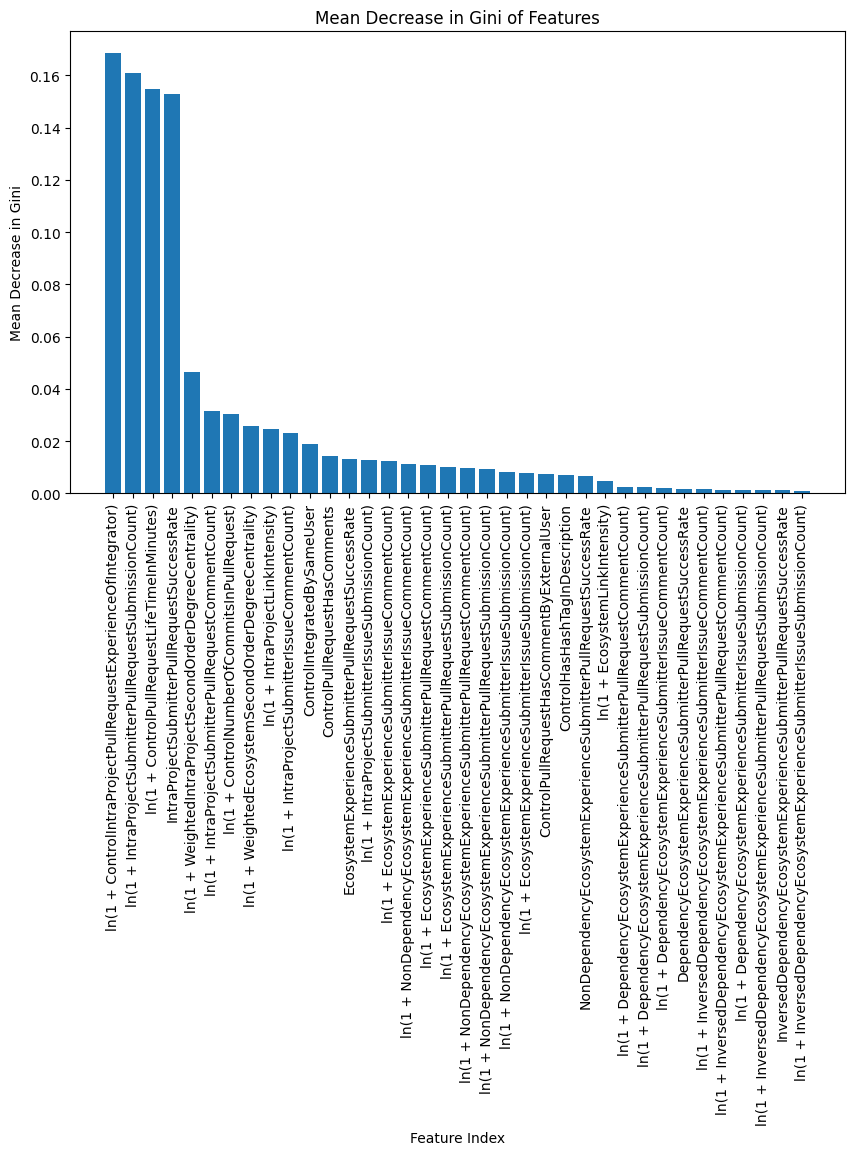

In [15]:
from matplotlib import pyplot as plt

feature_importances = full_rf_model.feature_importances_

sorted_indices = np.argsort(feature_importances)[::-1]
sorted_importances = feature_importances[sorted_indices]

# Step 4: Plot the mean decrease accuracy plot
plt.figure(figsize=(10, 6))
plt.bar(range(test_predictors.shape[1]), sorted_importances)
plt.xlabel("Feature Index")
plt.ylabel("Mean Decrease in Gini")
plt.title("Mean Decrease in Gini of Features")
ordererd_columns = np.array(test_predictors.columns)[sorted_indices]
plt.xticks(range(test_predictors.shape[1]), ordererd_columns, rotation=90)
plt.tight_layout()
plt.show()

In [16]:
# Stores feature importances in file.
output_file = f"{figure_base_path}/feature_importance.txt"
with open(output_file, "w+", encoding="utf-8") as output_file:
    for field, importance in zip(ordererd_columns, sorted_importances):
        entry = f"{field}: {importance}"
        output_file.write(f'{entry}\n')
        print(entry)

ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator): 0.1684385077008697
ln(1 + IntraProjectSubmitterPullRequestSubmissionCount): 0.1610072923385928
ln(1 + ControlPullRequestLifeTimeInMinutes): 0.1548957353370765
IntraProjectSubmitterPullRequestSuccessRate: 0.15292330588685338
ln(1 + WeightedIntraProjectSecondOrderDegreeCentrality): 0.0464017026678719
ln(1 + IntraProjectSubmitterPullRequestCommentCount): 0.03164251600576754
ln(1 + ControlNumberOfCommitsInPullRequest): 0.030244626206435865
ln(1 + WeightedEcosystemSecondOrderDegreeCentrality): 0.02580808439364022
ln(1 + IntraProjectLinkIntensity): 0.02468392300374083
ln(1 + IntraProjectSubmitterIssueCommentCount): 0.02319048849401429
ControlIntegratedBySameUser: 0.01876816825561181
ControlPullRequestHasComments: 0.014355952045440493
EcosystemExperienceSubmitterPullRequestSuccessRate: 0.013035629077312899
ln(1 + IntraProjectSubmitterIssueSubmissionCount): 0.012696930804232537
ln(1 + EcosystemExperienceSubmitterIssueCommentCount): 

### Variable Group Reverse Ablation Studies

Creates a model with a subset of features.
Compared to regular ablation, it tests "what happens if I add a feature", instead of "what happens when I remove one".

In [17]:
rev_abl_results = dict()

for cluster_name, cluster in var_groups.items():
    print(f'Reverse ablation with "{str(cluster_name)}", including: {cluster}.')

    # Creates models
    f1_scores, f1_mean, f1_std = kfold_rf_evaluation(
        df, cluster, k, pr_merged_key, seed_counter
    )
    rev_abl_results[cluster_name] = (f1_scores, f1_mean, f1_std)

    print(
        f"Performance of '{cluster_name}'\n{list(cluster)}\n{f1_scores=}\n{f1_mean=}, {f1_std=}\n"
    )

Reverse ablation with "FeatureGroups.Control", including: ['ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlPullRequestHasCommentByExternalUser', 'ControlHasHashTagInDescription', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)'].


random_state=50
random_state=50
random_state=50
random_state=50
random_state=50
metrics={'accuracy': 0.860479993919317, 'precision': 0.8964227539970498, 'recall': 0.9467579261359441, 'f1': 0.9209030418592291}

Confusion matrix:
[[  7623  14816]
 [  7211 128227]]

Classification report:
metrics={'accuracy': 0.8606392277581424, 'precision': 0.8954309050926734, 'recall': 0.9480889059716606, 'f1': 0.9210078482339679}

Confusion matrix:
[[  7610  14979]
 [  7023 128266]]

Classification report:
metrics={'accuracy': 0.8599804912654074, 'precision': 0.8951818828749634, 'recall': 0.9476926258567715, 'f1': 0.9206891355668291}

Confusion matrix:
[[  7462  15024]
 [  7082 128310]]

Classification report:
              precision    recall  f1-score   support

       False       0.51      0.34      0.41     22439
        True       0.90      0.95      0.92    135438

    accuracy                           0.86    157877
   macro avg       0.71      0.64      0.66    157877
weighted avg       0.84  

In [18]:
# Prints summarized results again for clarity.
print("Reverse cluster ablation results:")
for cluster_name, (f1_scores, f1_mean, f1_std) in rev_abl_results.items():
    print(f"Cluster '{cluster_name}':\n{f1_scores=}\n{f1_mean=}, {f1_std=}\n")

Reverse cluster ablation results:
Cluster 'FeatureGroups.Control':
f1_scores=[0.9209030418592291, 0.9210078482339679, 0.9206891355668291, 0.9200448669092165, 0.9207390927747607]
f1_mean=0.9206767970688006, f1_std=0.00033590186044775156

Cluster 'FeatureGroups.Intra':
f1_scores=[0.9241854438580414, 0.9247905185018559, 0.9239691672847035, 0.9245283681590992, 0.9247503616420656]
f1_mean=0.9244447718891532, f1_std=0.000320426253956653

Cluster 'FeatureGroups.Eco':
f1_scores=[0.9197560090546214, 0.9205203461138247, 0.9201116970907608, 0.9202188362393918, 0.9204837924017922]
f1_mean=0.9202181361800781, f1_std=0.0002781349751797398

Cluster 'FeatureGroups.DEco':
f1_scores=[0.9221013625766578, 0.9230637896828785, 0.9229329535480214, 0.9221562207351001, 0.922382949058364]
f1_mean=0.9225274551202043, f1_std=0.0003980792796263914

Cluster 'FeatureGroups.IDEco':
f1_scores=[0.9223163310977256, 0.9225114687125324, 0.9227916189955772, 0.9229513849767663, 0.9224457167844112]
f1_mean=0.9226033041134025

### Probability Guesser

Guesses the outcome by simply considering the probability of a merged pull request.
Technically, an RF model performs somewhat well when its performance scores are ``> 0.5`` as there are only two possible outcomes.
However, they actually mean anything once it's better than a simple probability guesser.

In [19]:
import random

from python_proj.modelling.notebooks.random_forest.rf_functions import calculate_metrics

random.seed(seed_counter.get_next())

probability_true = class_imbalance / (class_imbalance + 1)

predictions = [random.random() < probability_true for _ in range(len(test_dependent))]
metrics = calculate_metrics(predictions, test_dependent)

print(f"Probability guesser metrics with {probability_true=}.")
print(json.dumps(metrics, indent=4))

Probability guesser metrics with probability_true=0.8570717352281322.
{
    "accuracy": 0.7559761334701478,
    "precision": 0.8578772814902905,
    "recall": 0.8575985586330643,
    "f1": 0.8577378974188544
}


In [20]:
import datetime

print(datetime.datetime.now())

2024-02-20 15:16:11.461852
